In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir -p ~/.kaggle
!cp "/content/gdrive/My Drive/kaggleJson/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masud1901/binary-classification-data-for-apnea-detection
!unzip binary-classification-data-for-apnea-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Binary_Classification_Apnea/non_apnea/31576.png  
  inflating: Binary_Classification_Apnea/non_apnea/31577.png  
  inflating: Binary_Classification_Apnea/non_apnea/31578.png  
  inflating: Binary_Classification_Apnea/non_apnea/31579.png  
  inflating: Binary_Classification_Apnea/non_apnea/31580.png  
  inflating: Binary_Classification_Apnea/non_apnea/31581.png  
  inflating: Binary_Classification_Apnea/non_apnea/31582.png  
  inflating: Binary_Classification_Apnea/non_apnea/31583.png  
  inflating: Binary_Classification_Apnea/non_apnea/31584.png  
  inflating: Binary_Classification_Apnea/non_apnea/31585.png  
  inflating: Binary_Classification_Apnea/non_apnea/31586.png  
  inflating: Binary_Classification_Apnea/non_apnea/31587.png  
  inflating: Binary_Classification_Apnea/non_apnea/31588.png  
  inflating: Binary_Classification_Apnea/non_apnea/31589.png  
  inflating: Binary_Classification_Apnea/non_apnea/31590.png  
  in

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

def load_images(folder, target_size=(128, 180), num_images=None):
    all_image_files = [f for f in os.listdir(folder) if f.endswith((".png", ".jpg", ".jpeg"))]

    if num_images is not None:
        num_images = min(num_images, len(all_image_files))
        selected_files = random.sample(all_image_files, num_images)
    else:
        selected_files = all_image_files

    images = []
    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = io.imread(img_path, as_gray=True)
            img = transform.resize(img, target_size, anti_aliasing=True)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {filename}: {str(e)}")

    return np.array(images)


def plot_sample_images(apnea_images, non_apnea_images, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    for i in range(num_samples):
        if i < len(apnea_images):
            axes[0, i].imshow(apnea_images[i], cmap="gray")
            axes[0, i].set_title(f"Apnea {i+1}")
            axes[0, i].axis("off")

        if i < len(non_apnea_images):
            axes[1, i].imshow(non_apnea_images[i], cmap="gray")
            axes[1, i].set_title(f"Non-Apnea {i+1}")
            axes[1, i].axis("off")
    plt.tight_layout()
    plt.show()


def plot_average_images(apnea_images, non_apnea_images):
    avg_apnea = np.mean(apnea_images, axis=0)
    avg_non_apnea = np.mean(non_apnea_images, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(avg_apnea, cmap="gray")
    ax1.set_title("Average Apnea Spectrogram")
    ax1.axis("off")

    ax2.imshow(avg_non_apnea, cmap="gray")
    ax2.set_title("Average Non-Apnea Spectrogram")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


def plot_pixel_intensity_histograms(apnea_images, non_apnea_images):
    apnea_hist = np.histogram(apnea_images.flatten(), bins=256, range=(0, 1))[0]
    non_apnea_hist = np.histogram(non_apnea_images.flatten(), bins=256, range=(0, 1))[0]

    plt.figure(figsize=(10, 6))
    plt.plot(apnea_hist, label="Apnea", alpha=0.7)
    plt.plot(non_apnea_hist, label="Non-Apnea", alpha=0.7)
    plt.title("Pixel Intensity Histograms")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()



def extract_glcm_features(image):
    # Convert float image (0-1) to uint8 (0-255)
    image_uint8 = (image * 255).astype(np.uint8)

    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(image_uint8, distances, angles, 256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return [contrast, dissimilarity, homogeneity, energy, correlation]


def plot_glcm_features(apnea_images, non_apnea_images):
    # Diagnostic information
    print(f"Shape of apnea_images: {apnea_images.shape}")
    print(f"Shape of non_apnea_images: {non_apnea_images.shape}")
    print(f"Data type of apnea_images: {apnea_images.dtype}")
    print(f"Data type of non_apnea_images: {non_apnea_images.dtype}")
    print(f"Min value in apnea_images: {np.min(apnea_images)}")
    print(f"Max value in apnea_images: {np.max(apnea_images)}")
    print(f"Min value in non_apnea_images: {np.min(non_apnea_images)}")
    print(f"Max value in non_apnea_images: {np.max(non_apnea_images)}")

    # Check if images are already in integer format
    if np.issubdtype(apnea_images.dtype, np.integer) and np.issubdtype(non_apnea_images.dtype, np.integer):
        print("Images are already in integer format")
    else:
        print("Images are in float format")

    # Rest of the function remains the same
    apnea_features = np.array([extract_glcm_features(img) for img in apnea_images])
    non_apnea_features = np.array(
        [extract_glcm_features(img) for img in non_apnea_images]
    )

    feature_names = [
        "Contrast",
        "Dissimilarity",
        "Homogeneity",
        "Energy",
        "Correlation",
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        axes[i].boxplot(
            [apnea_features[:, i], non_apnea_features[:, i]],
            labels=["Apnea", "Non-Apnea"],
        )
        axes[i].set_title(feature)

    plt.tight_layout()
    plt.show()

def dimensionality_reduction(apnea_images, non_apnea_images):
    X = np.vstack(
        (
            apnea_images.reshape(len(apnea_images), -1),
            non_apnea_images.reshape(len(non_apnea_images), -1),
        )
    )
    y = np.hstack((np.ones(len(apnea_images)), np.zeros(len(non_apnea_images))))

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    tsne = TSNE(n_components=3, random_state=42)
    X_tsne = tsne.fit_transform(X)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c="r", label="Apnea", alpha=0.7)
    ax1.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c="b", label="Non-Apnea", alpha=0.7)
    ax1.set_title("PCA")
    ax1.legend()

    ax2.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], c="r", label="Apnea", alpha=0.7)
    ax2.scatter(
        X_tsne[y == 0, 0], X_tsne[y == 0, 1], c="b", label="Non-Apnea", alpha=0.7
    )
    ax2.set_title("t-SNE")
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Main execution
apnea_folder = "./Binary_Classification_Apnea/apnea/"
non_apnea_folder = "./Binary_Classification_Apnea/non_apnea/"

apnea_images = load_images(apnea_folder,num_images=5000)
non_apnea_images = load_images(non_apnea_folder,num_images=5000)

print(f"Number of Apnea images: {len(apnea_images)}")
print(f"Number of Non-Apnea images: {len(non_apnea_images)}")


Number of Apnea images: 5000
Number of Non-Apnea images: 5000


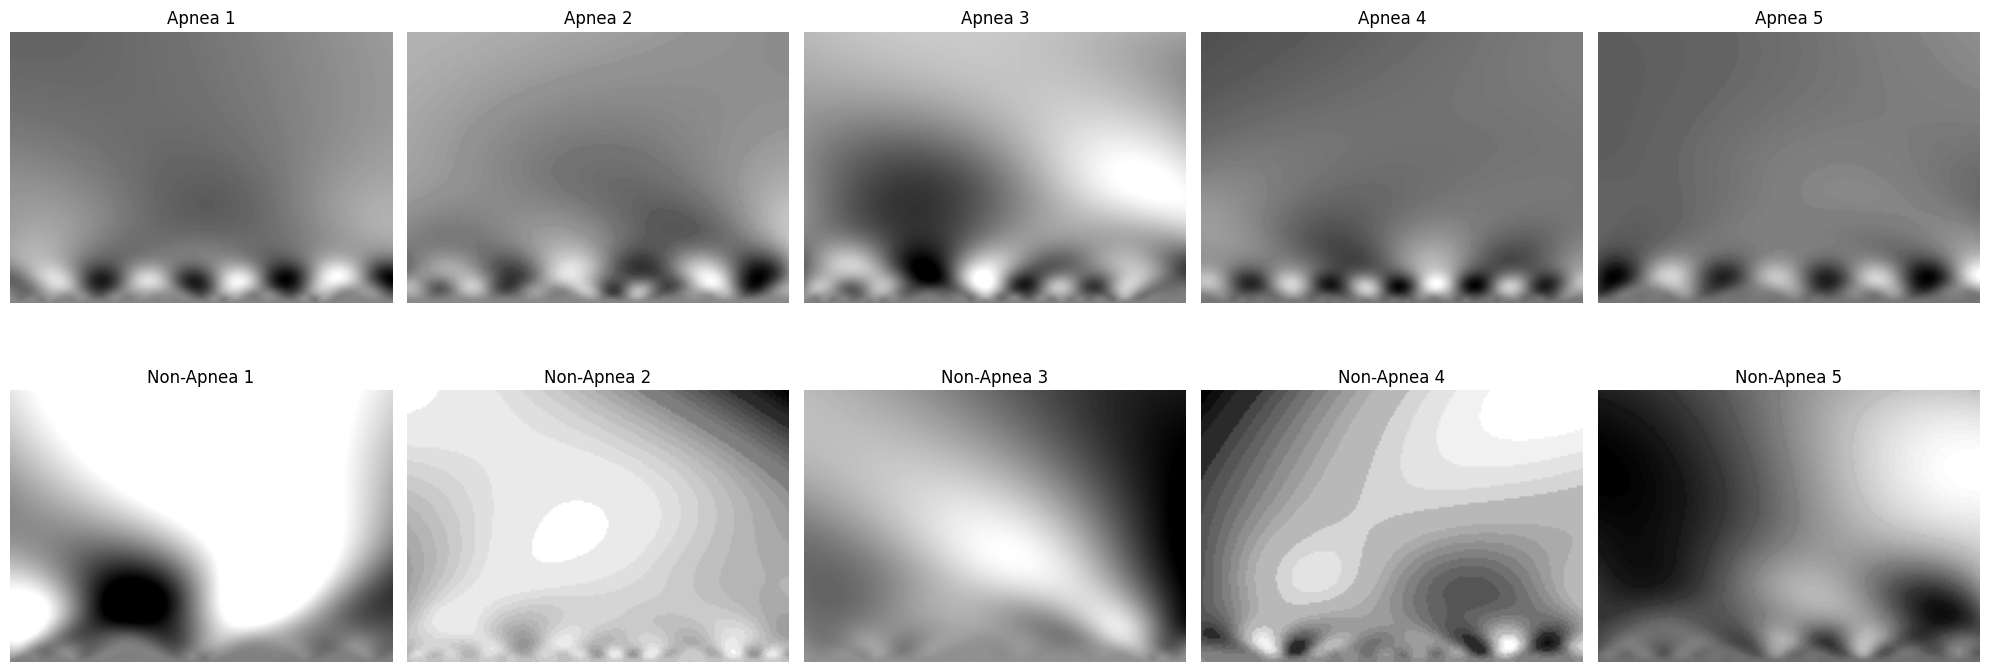

In [6]:
plot_sample_images(apnea_images, non_apnea_images)

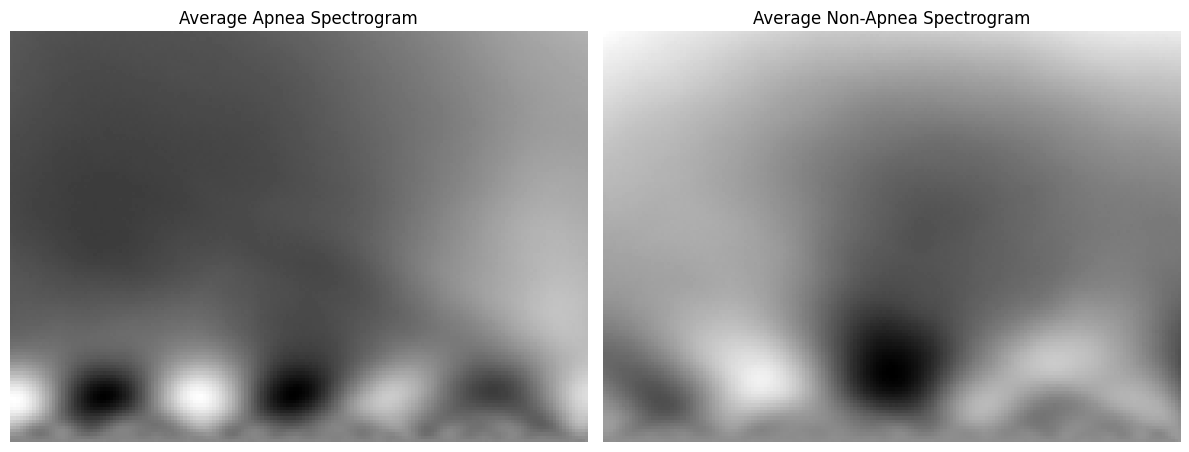

In [7]:
plot_average_images(apnea_images, non_apnea_images)

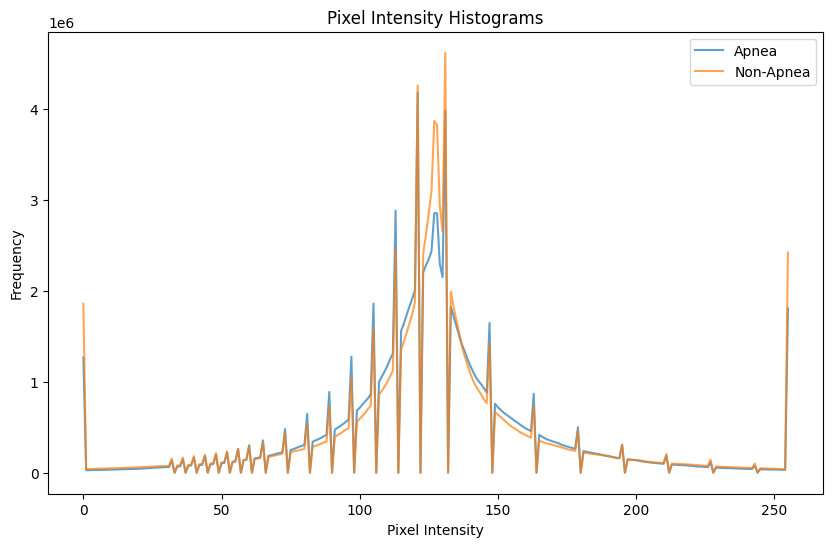

In [8]:
plot_pixel_intensity_histograms(apnea_images, non_apnea_images)

Shape of apnea_images: (5000, 128, 180)
Shape of non_apnea_images: (5000, 128, 180)
Data type of apnea_images: float64
Data type of non_apnea_images: float64
Min value in apnea_images: 0.0
Max value in apnea_images: 1.0
Min value in non_apnea_images: 0.0
Max value in non_apnea_images: 1.0
Images are in float format


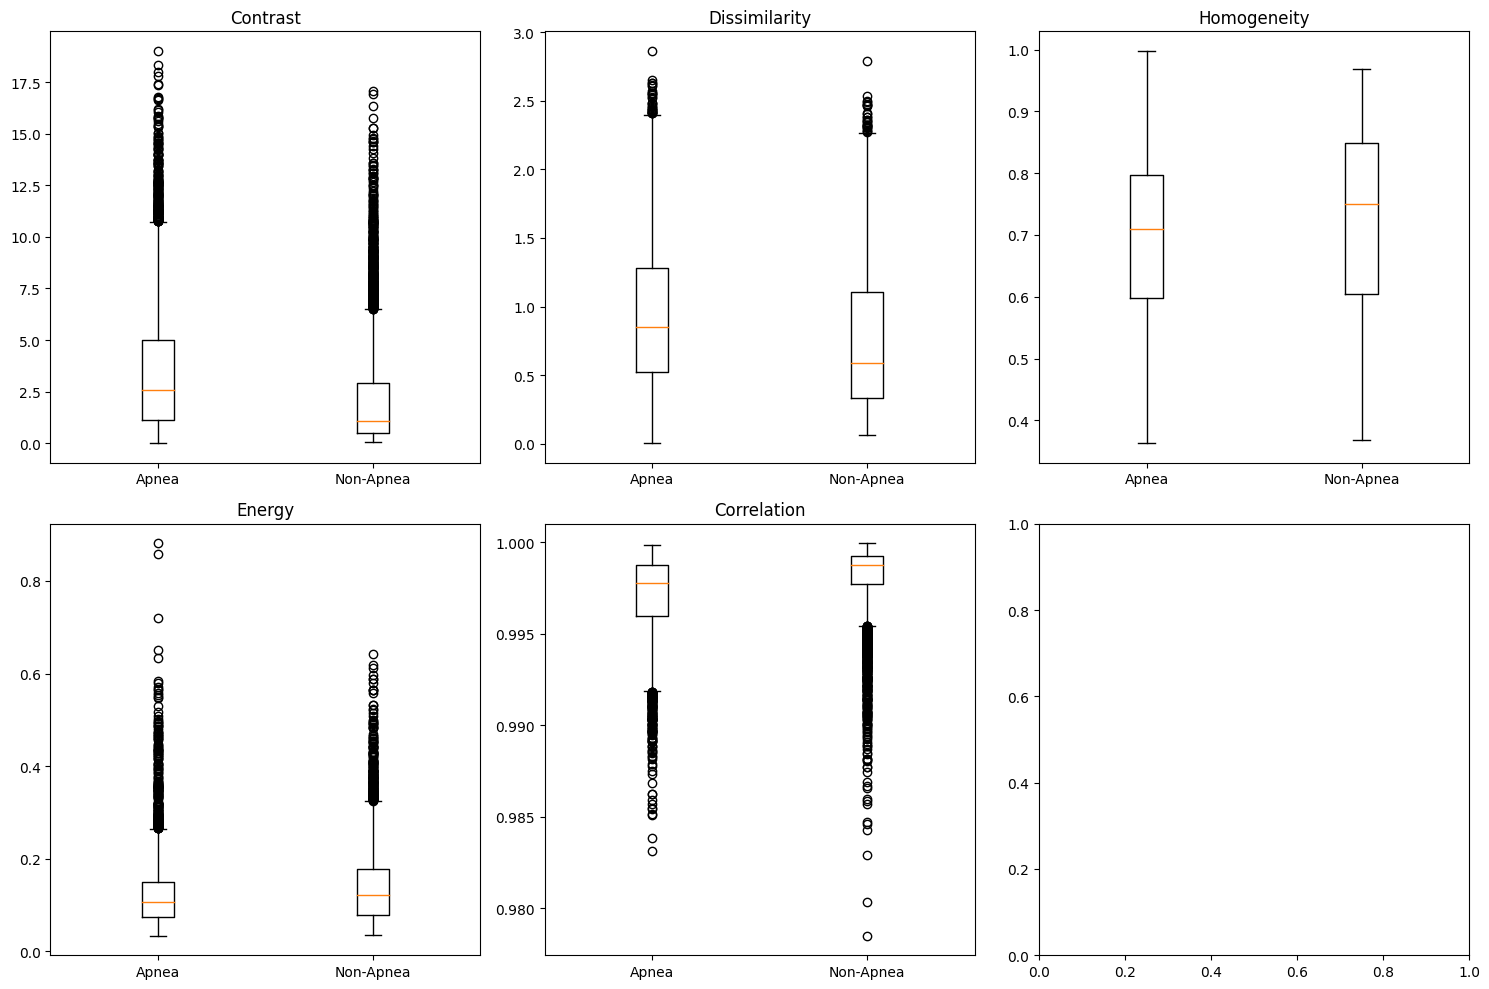

In [9]:
plot_glcm_features(apnea_images, non_apnea_images)

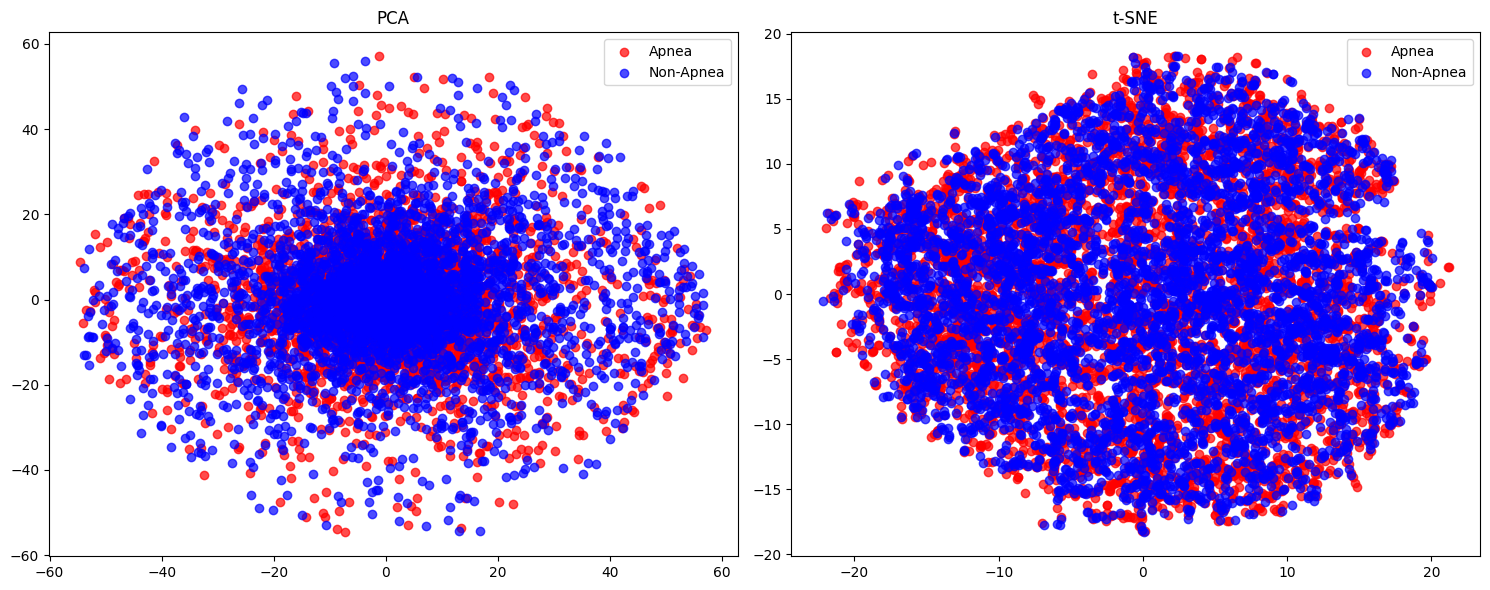

In [10]:
dimensionality_reduction(apnea_images, non_apnea_images)

In [11]:
import numpy as np
import pandas as pd
from skimage import measure
from scipy import stats
from tqdm import tqdm

def measure_image_metrics(image, label, index):
    return {
        'Label': label,
        'Image_Index': index,
        'Mean_Intensity': np.mean(image),
        'Std_Intensity': np.std(image),
        'Min_Intensity': np.min(image),
        'Max_Intensity': np.max(image),
        'Entropy': measure.shannon_entropy(image),
        'SNR': np.mean(image) / np.std(image) if np.std(image) != 0 else 0,
        'Contrast': np.max(image) - np.min(image),
        'Skewness': stats.skew(image.flatten()),
        'Kurtosis': stats.kurtosis(image.flatten()),
        '10th_Percentile': np.percentile(image, 10),
        '90th_Percentile': np.percentile(image, 90),
    }

def create_metrics_dataframe(apnea_images, non_apnea_images, batch_size=100):
    total_images = len(apnea_images) + len(non_apnea_images)
    metrics = []

    with tqdm(total=total_images, desc="Processing Images") as pbar:
        for i in range(0, len(apnea_images), batch_size):
            batch = apnea_images[i:i+batch_size]
            metrics.extend([measure_image_metrics(img, 'Apnea', idx) for idx, img in enumerate(batch, start=i)])
            pbar.update(len(batch))

        for i in range(0, len(non_apnea_images), batch_size):
            batch = non_apnea_images[i:i+batch_size]
            metrics.extend([measure_image_metrics(img, 'Non-Apnea', idx) for idx, img in enumerate(batch, start=i)])
            pbar.update(len(batch))

    df = pd.DataFrame(metrics)
    return df

# Assuming apnea_images and non_apnea_images are already loaded
print("Starting metrics calculation...")
df_metrics = create_metrics_dataframe(apnea_images, non_apnea_images)

print("\nSummary statistics:")
print(df_metrics.groupby('Label').mean())

print("\nSaving metrics to CSV...")
df_metrics.to_csv('image_metrics.csv', index=False)
print("Full metrics saved to 'image_metrics.csv'")

# Additional analysis
print("\nPerforming additional analysis...")
for column in df_metrics.columns:
    if column not in ['Label', 'Image_Index']:
        t_stat, p_value = stats.ttest_ind(
            df_metrics[df_metrics['Label'] == 'Apnea'][column],
            df_metrics[df_metrics['Label'] == 'Non-Apnea'][column]
        )
        print(f"{column}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

Starting metrics calculation...


Processing Images: 100%|██████████| 10000/10000 [00:50<00:00, 197.50it/s]



Summary statistics:
           Image_Index  Mean_Intensity  Std_Intensity  Min_Intensity  \
Label                                                                  
Apnea           2499.5        0.498655       0.113797       0.218907   
Non-Apnea       2499.5        0.500208       0.113792       0.261068   

           Max_Intensity   Entropy       SNR  Contrast  Skewness  Kurtosis  \
Label                                                                        
Apnea           0.792530  6.049353  6.909719  0.573623  0.087206  0.388571   
Non-Apnea       0.743728  5.839320  8.959699  0.482660  0.007047 -0.297564   

           10th_Percentile  90th_Percentile  
Label                                        
Apnea             0.351951         0.644143  
Non-Apnea         0.350269         0.649544  

Saving metrics to CSV...
Full metrics saved to 'image_metrics.csv'

Performing additional analysis...
Mean_Intensity: t-statistic = -0.9448, p-value = 0.3448
Std_Intensity: t-statistic = 0.003

In [12]:
df_metrics

,Label,Image_Index,Mean_Intensity,Std_Intensity,Min_Intensity,Max_Intensity,Entropy,SNR,Contrast,Skewness,Kurtosis,10th_Percentile,90th_Percentile
0,Apnea,0,0.481661,0.080431,0.121569,0.850980,5.943013,5.988523,0.729412,0.396651,2.785864,0.411765,0.576471
1,Apnea,1,0.503738,0.034741,0.329412,0.650980,4.869069,14.499900,0.321569,-0.572615,2.676531,0.462745,0.541176
2,Apnea,2,0.608601,0.205611,0.000000,1.000000,7.364493,2.959966,1.000000,-0.446464,-0.271517,0.305882,0.839216
3,Apnea,3,0.492964,0.044408,0.274510,0.764706,5.028829,11.100852,0.490196,0.545192,5.083624,0.443137,0.537255
4,Apnea,4,0.496181,0.032750,0.337255,0.690196,4.447204,15.150404,0.352941,-0.178396,5.548577,0.466667,0.521569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Non-Apnea,4995,0.466114,0.036927,0.349020,0.541176,4.876944,12.622687,0.192157,-0.154413,-0.866744,0.423529,0.513725
9996,Non-Apnea,4996,0.441263,0.075858,0.294118,0.694118,6.019398,5.816980,0.400000,0.397324,-0.149921,0.345098,0.541176
9997,Non-Apnea,4997,0.428640,0.118836,0.039216,0.596078,6.107302,3.606981,0.556863,-1.441367,1.222539,0.231373,0.529412
9998,Non-Apnea,4998,0.466652,0.104989,0.215686,0.752941,6.487069,4.444757,0.537255,-0.205783,-0.218888,0.313725,0.600000


In [15]:
import os
import cv2  # For image reading
import numpy as np
from skimage import filters, measure
from scipy.stats import skew, kurtosis
import shutil

# Function to compute Signal-to-Noise Ratio (SNR)
def compute_snr(image):
    signal = np.mean(image)
    noise = np.std(image)
    return signal / noise if noise != 0 else 0

# Function to compute entropy
def compute_entropy(image):
    histogram, _ = np.histogram(image, bins=256, range=(0, 1), density=True)
    histogram = histogram + 1e-10  # avoid log(0)
    return -np.sum(histogram * np.log2(histogram))

# Function to compute contrast
def compute_contrast(image):
    return np.std(image) / np.mean(image)

# Function to calculate key image metrics
def calculate_image_metrics(image):
    image = image.astype(float) / 255.0  # Normalize to [0,1] range
    snr = compute_snr(image)
    entropy = compute_entropy(image)
    contrast = compute_contrast(image)
    img_skew = skew(image.flatten())
    img_kurtosis = kurtosis(image.flatten())
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    return snr, entropy, contrast, img_skew, img_kurtosis, min_intensity, max_intensity

# Filtering function based on dynamic threshold
def check_criteria(criteria, threshold):
    return sum(criteria) >= threshold

# Filtering function for Apnea images (threshold increased by 1)
def filter_apnea_image(image_metrics):
    snr, entropy, contrast, img_skew, img_kurtosis, min_intensity, max_intensity = image_metrics
    # Check conditions for Apnea images
    criteria = [
        snr < 7.5,
        entropy > 5.9,
        contrast > 0.55,
        img_skew > 0.05,
        img_kurtosis > 0.2,
        min_intensity < 0.23,
        max_intensity > 0.75
    ]
    # Apply filter with increased threshold (3 instead of 4)
    return check_criteria(criteria, threshold=3)

# Filtering function for Non-Apnea images (threshold increased by 2)
def filter_non_apnea_image(image_metrics):
    snr, entropy, contrast, img_skew, img_kurtosis, min_intensity, max_intensity = image_metrics
    # Check conditions for Non-Apnea images
    criteria = [
        snr > 8.5,
        entropy < 5.9,
        contrast < 0.5,
        img_skew < 0.05,
        img_kurtosis < 0,
        min_intensity > 0.26,
        max_intensity < 0.75
    ]
    # Apply filter with increased threshold (6 instead of 4)
    return check_criteria(criteria, threshold=6)

# Main function to process images and apply filtering
def filter_images(input_folder, output_folder, is_apnea):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_file in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if img is None:
            continue

        # Calculate image metrics
        metrics = calculate_image_metrics(img)

        # Apply filters based on whether it's an Apnea or Non-Apnea folder
        if is_apnea and filter_apnea_image(metrics):
            shutil.copy(img_path, os.path.join(output_folder, img_file))
        elif not is_apnea and filter_non_apnea_image(metrics):
            shutil.copy(img_path, os.path.join(output_folder, img_file))


# Driver function to run the script
if __name__ == "__main__":
    # Set the input folders for Apnea and Non-Apnea images
    apnea_input_folder = './Binary_Classification_Apnea/apnea'
    non_apnea_input_folder = './Binary_Classification_Apnea/non_apnea'

    # Set the output folders for filtered Apnea and Non-Apnea images
    apnea_output_folder = './BCA/apnea'
    non_apnea_output_folder = './BCA/non_apnea'

    # Filter Apnea images
    print("Filtering Apnea images...")
    filter_images(apnea_input_folder, apnea_output_folder, is_apnea=True)

    # Filter Non-Apnea images
    print("Filtering Non-Apnea images...")
    filter_images(non_apnea_input_folder, non_apnea_output_folder, is_apnea=False)

    print("Filtering complete!")


Filtering Apnea images...
Filtering Non-Apnea images...
Filtering complete!
